    1) 실시간 위치 인증이 맞는가?
    Users frequently 'check-in' with the app to update their current location, which is then broadcast to their friends.
    -> 실시간 위치인증 맞음. brightkite 또한 실시간 위치인증이 맞다고 함.

    2) 중분류 마치기 -> 아직 진행중. 뉴욕과 도쿄 유저에 대한 데이터셋이 별도로 있는데, 이 경우 카테고리가 보다 적어 

In [4]:
import numpy as np
import pandas as pd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
import math

In [5]:
# UTC_time 변경 함수

def date_convert(date_to_convert):
    pru = datetime.datetime.strptime(date_to_convert, '%a %b %d %H:%M:%S +0000 %Y')+ datetime.timedelta(hours=-240//60)
    return pru.strftime('%b %d %Y %H:%M:%S')

def tzo_convert(tzo_to_convert):
    return  timedelta(hours=tzo_to_convert/60)

In [19]:
nyc_filepath = 'C:/Users/piai/Desktop/code_file/dataset_WWW2019/dataset_TSMC2014_NYC.csv\dataset_TSMC2014_NYC.csv'
custom_date_parser = lambda x: datetime.strptime(x, "%a %b %d %H:%M:%S +0000 %Y")

nyc_data = pd.read_csv(nyc_filepath,parse_dates=['utcTimestamp'],date_parser=custom_date_parser)

nyc_data["utcTimestampOffset"] = nyc_data.utcTimestamp + nyc_data.timezoneOffset.apply(tzo_convert)

nyc_data["hour"] = nyc_data.utcTimestampOffset.dt.hour

# 야행성인지 체크하는 컬럼 생성. 저녁 6시부터 새벽 6시까지 활동한 POI는 야행성 Ture로 표시.
nyc_data["nightlife"] = nyc_data['hour'].apply(lambda x: 'True' if (18 <= x < 24) or (0 <= x < 6)else 'False')

# 요일이 무엇인지 0~6 순서로 설정. 월요일이 0, 일요일이 6.
nyc_data["dayofweek"] = nyc_data.utcTimestampOffset.dt.dayofweek

# 평일과 주말을 구분. 평일이면 True, 주말이면 False.
nyc_data["weekday"] = nyc_data['dayofweek'].apply(lambda x: 'True' if x <= 4 else 'False')

In [25]:
# 카테고리는 519개가 존재한다.
nyc_data['venueCategory'].drop_duplicates().count()

251

In [26]:
nyc_data['venueCategory'].drop_duplicates()

0         Arts & Crafts Store
1                      Bridge
2              Home (private)
3              Medical Center
4                  Food Truck
                 ...         
102807        Photography Lab
110352          Garden Center
139848           Music School
158923                 Castle
167530            Pet Service
Name: venueCategory, Length: 251, dtype: object

<AxesSubplot:xlabel='dayofweek'>

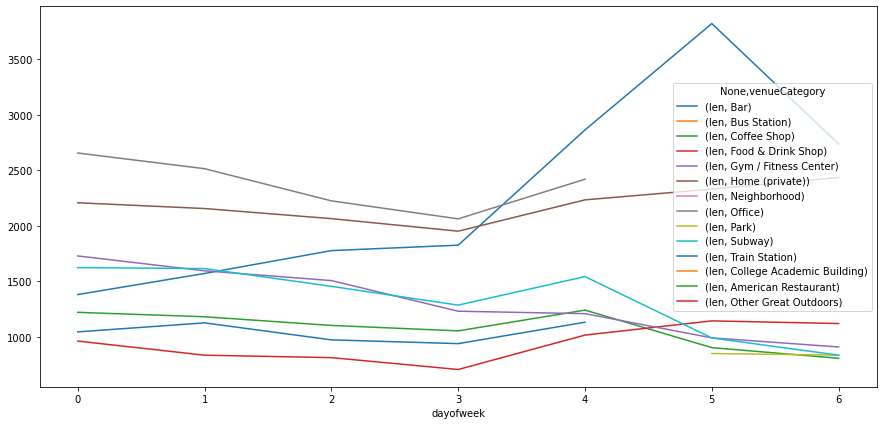

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
pru= nyc_data.groupby([ 'dayofweek','venueCategory']).venueId.agg([len])
pru2 =pru.query('len > 700')
pru2.unstack().plot(ax=ax)

<AxesSubplot:>

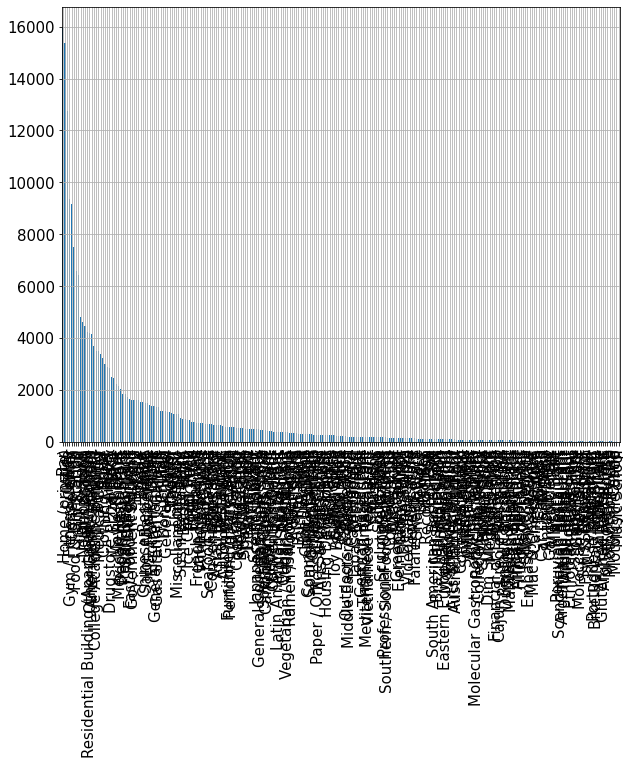

In [27]:
CountStatus = pd.value_counts(nyc_data['venueCategory'], sort=True)
CountStatus.plot.bar()
CountStatus.plot.bar(grid=True, figsize=(10,8), fontsize=15)  # figsize, fontsize 조정

In [21]:
nyc_data

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,2012-04-03 14:00:09,14,False,1,True
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25,2012-04-03 14:00:25,14,False,1,True
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24,2012-04-03 14:02:24,14,False,1,True
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,2012-04-03 18:02:41,2012-04-03 14:02:41,14,False,1,True
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,2012-04-03 18:03:00,2012-04-03 14:03:00,14,False,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227423,688,3fd66200f964a52000e71ee3,4bf58dd8d48988d1e7931735,Music Venue,40.733596,-74.003139,-300,2013-02-16 02:29:11,2013-02-15 21:29:11,21,True,4,True
227424,560,4bca32ff0687ef3be789dbcc,4bf58dd8d48988d16c941735,Burger Joint,40.745719,-73.993720,-300,2013-02-16 02:31:35,2013-02-15 21:31:35,21,True,4,True
227425,945,50a77716e4b0b5a9492f6f56,4bf58dd8d48988d103941735,Home (private),40.854365,-73.883070,-300,2013-02-16 02:33:16,2013-02-15 21:33:16,21,True,4,True
227426,671,4514efe0f964a520e7391fe3,4bf58dd8d48988d11d941735,Bar,40.735981,-74.029309,-300,2013-02-16 02:34:31,2013-02-15 21:34:31,21,True,4,True


In [28]:
nyc_data[nyc_data['userId'] == 979].sort_values('utcTimestampOffset').head(30)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25,2012-04-03 14:00:25,14,False,1,True
712,979,4a357950f964a520079d1fe3,4bf58dd8d48988d146941735,Deli / Bodega,40.718789,-73.992808,-240,2012-04-04 00:03:53,2012-04-03 20:03:53,20,True,1,True
2004,979,4c006f47efa2ef3bf74baa8c,4bf58dd8d48988d1e2941735,Beach,40.573935,-74.084287,-240,2012-04-04 17:21:27,2012-04-04 13:21:27,13,False,2,True
2012,979,4e2c85ccd164223a698d6b22,4bf58dd8d48988d1e2941735,Beach,40.590579,-74.066205,-240,2012-04-04 17:24:08,2012-04-04 13:24:08,13,False,2,True
2052,979,4a32c3f9f964a5208c9a1fe3,4bf58dd8d48988d1df941735,Bridge,40.705888,-73.990002,-240,2012-04-04 17:46:09,2012-04-04 13:46:09,13,False,2,True
3459,979,49c27575f964a520f1551fe3,4bf58dd8d48988d1fa941735,Food & Drink Shop,40.736527,-73.990560,-240,2012-04-07 16:00:18,2012-04-07 12:00:18,12,False,5,False
3755,979,40abf500f964a52035f31ee3,4bf58dd8d48988d163941735,Park,40.730836,-73.997641,-240,2012-04-07 18:29:44,2012-04-07 14:29:44,14,False,5,False
4252,979,4e2c85ccd164223a698d6b22,4bf58dd8d48988d1e2941735,Beach,40.590579,-74.066205,-240,2012-04-07 22:16:37,2012-04-07 18:16:37,18,True,5,False
5089,979,4c006f47efa2ef3bf74baa8c,4bf58dd8d48988d1e2941735,Beach,40.573935,-74.084287,-240,2012-04-08 11:33:17,2012-04-08 07:33:17,7,False,6,False
5094,979,4e2c85ccd164223a698d6b22,4bf58dd8d48988d1e2941735,Beach,40.590579,-74.066205,-240,2012-04-08 11:36:57,2012-04-08 07:36:57,7,False,6,False


In [29]:
# 이 사용자는 저녁만 되면 먹고 논다. 여러번 중복해서 장소인증을 하는 듯 함.
nyc_data[nyc_data['userId'] == 470].sort_values('utcTimestampOffset').head(30)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,2012-04-03 14:00:09,14,False,1,True
626,470,4e08ad8cd4c03ae0b9d11f93,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.683178,-73.965746,-240,2012-04-03 23:36:34,2012-04-03 19:36:34,19,True,1,True
650,470,4be09b7fcb81c9b62069668b,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.624513,-73.965070,-240,2012-04-03 23:46:46,2012-04-03 19:46:46,19,True,1,True
652,470,49f50c9ff964a5208a6b1fe3,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.677611,-73.963748,-240,2012-04-03 23:47:16,2012-04-03 19:47:16,19,True,1,True
654,470,4a6a09b1f964a52071cc1fe3,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.702752,-73.990696,-240,2012-04-03 23:47:49,2012-04-03 19:47:49,19,True,1,True
655,470,49e63b62f964a52027641fe3,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.687583,-73.989895,-240,2012-04-03 23:48:15,2012-04-03 19:48:15,19,True,1,True
660,470,45795395f964a520d23e1fe3,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.679694,-73.974252,-240,2012-04-03 23:48:51,2012-04-03 19:48:51,19,True,1,True
674,470,4c9d89017ada199cf0a493bc,4bf58dd8d48988d111941735,Japanese Restaurant,40.705436,-74.008348,-240,2012-04-03 23:51:33,2012-04-03 19:51:33,19,True,1,True
677,470,4b5b92def964a5201d0829e3,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.599278,-73.990891,-240,2012-04-03 23:52:01,2012-04-03 19:52:01,19,True,1,True
678,470,4baea553f964a5206dca3be3,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.657351,-73.956644,-240,2012-04-03 23:52:25,2012-04-03 19:52:25,19,True,1,True


In [30]:
nyc_data[nyc_data['userId'] == 69].sort_values('utcTimestampOffset').head(30)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24,2012-04-03 14:02:24,14,False,1,True
137,69,4bddaa53e75c0f47d219c503,4bf58dd8d48988d110951735,Salon / Barbershop,40.712859,-73.877419,-240,2012-04-03 19:34:56,2012-04-03 15:34:56,15,False,1,True
495,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-03 22:37:23,2012-04-03 18:37:23,18,True,1,True
702,69,4c3935bb93db0f47fa262392,4bf58dd8d48988d11d941735,Bar,40.712854,-73.878960,-240,2012-04-04 00:01:07,2012-04-03 20:01:07,20,True,1,True
1103,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-04 04:30:56,2012-04-04 00:30:56,0,True,2,True
2221,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-04 19:11:27,2012-04-04 15:11:27,15,False,2,True
3707,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-07 18:04:57,2012-04-07 14:04:57,14,False,5,False
4105,69,4b64e55df964a52032d82ae3,4bf58dd8d48988d12b951735,Bus Station,40.709347,-73.959650,-240,2012-04-07 21:01:38,2012-04-07 17:01:38,17,False,5,False
4269,69,4e4ac7bd14951b66ae92f888,4bf58dd8d48988d162941735,Other Great Outdoors,40.703714,-73.789092,-240,2012-04-07 22:28:27,2012-04-07 18:28:27,18,True,5,False
4271,69,4ca73f1cf47ea143485a6821,4bf58dd8d48988d1f9931735,Road,40.703154,-73.799215,-240,2012-04-07 22:28:44,2012-04-07 18:28:44,18,True,5,False


In [32]:
nyc_data['userId'].tolist

<bound method IndexOpsMixin.tolist of 0         470
1         979
2          69
3         395
4          87
         ... 
227423    688
227424    560
227425    945
227426    671
227427    942
Name: userId, Length: 227428, dtype: int64>

In [33]:
nyc_data[nyc_data['userId'] == 688].sort_values('utcTimestampOffset').head(30)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday
192,688,4cdc8c7699026dcb4a0c1481,4bf58dd8d48988d175941735,Gym / Fitness Center,40.744047,-73.984027,-240,2012-04-03 20:08:04,2012-04-03 16:08:04,16,False,1,True
1277,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-04 10:52:29,2012-04-04 06:52:29,6,False,2,True
2672,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-05 10:53:43,2012-04-05 06:53:43,6,False,3,True
3264,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-07 13:22:54,2012-04-07 09:22:54,9,False,5,False
3687,688,4cdc8c7699026dcb4a0c1481,4bf58dd8d48988d175941735,Gym / Fitness Center,40.744047,-73.984027,-240,2012-04-07 17:52:44,2012-04-07 13:52:44,13,False,5,False
3941,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-07 19:55:36,2012-04-07 15:55:36,15,False,5,False
4419,688,427c0500f964a52099211fe3,4bf58dd8d48988d1df931735,BBQ Joint,40.744378,-73.996205,-240,2012-04-07 23:41:56,2012-04-07 19:41:56,19,True,5,False
4711,688,4123ed80f964a5203b0c1fe3,4bf58dd8d48988d116941735,Bar,40.744525,-73.990908,-240,2012-04-08 02:30:38,2012-04-07 22:30:38,22,True,5,False
4805,688,4aa936ecf964a520815220e3,4bf58dd8d48988d11f941735,Bar,40.744541,-73.990595,-240,2012-04-08 03:28:26,2012-04-07 23:28:26,23,True,5,False
5135,688,4cdc8c7699026dcb4a0c1481,4bf58dd8d48988d175941735,Gym / Fitness Center,40.744047,-73.984027,-240,2012-04-08 12:51:38,2012-04-08 08:51:38,8,False,6,False


## Timedelta를 통해 현 POI와 다음 POI 간 체류시간을 계산해보기 전 드는 의문.
    1) 인증을 POI 이동할 때마다 하는 경우가 드문 것 같습니다. 체류시간에 대해 확인할 수 없거나 많은 왜곡이 생길 듯 한데(앞서 보는 것처럼 중복되는 케이스 또한 제거작업 필요), 우선 진행하고 분포도를 확인할까요?